In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset=MNIST(root='.', download=True,transform=ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size=128


In [5]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_loader=DataLoader(val_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)

# Model

In [6]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


images.shape: torch.Size([128, 1, 28, 28])


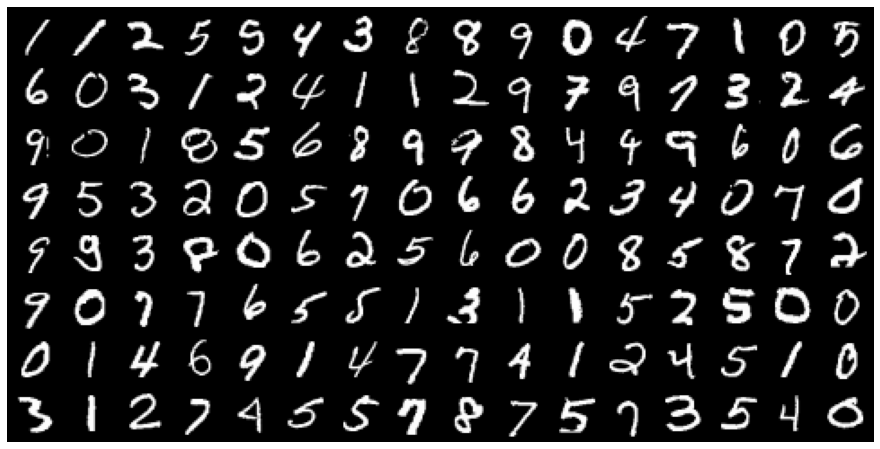

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [8]:
class MnistModel(nn.Module):

  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.linear1=nn.Linear(input_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,output_size)

  def forward(self,xb):
    #flatten the image 
    xb=xb.view(xb.size(0),-1)
    #hidden layer
    out=self.linear1(xb)
    #activaton
    out=F.relu(out)
    #output layer
    out=self.linear2(out)
    return out

In [9]:
torch.cuda.is_available()


True

In [10]:
input_size=784
num_classes=10
hidden_size=32

In [11]:
model=MnistModel(input_size,hidden_size=32,output_size=num_classes)

In [12]:
for t in model.parameters():
  print(t.shape)


torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [13]:
for images,labels in train_loader:
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print("loss:", loss.item())
  break

loss: 2.282956123352051


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return[to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [17]:
for images,labels in train_loader:
  images=to_device(images,device)
  print(images.device)
  break

cuda:0


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [18]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [19]:
train_dl=DeviceDataLoader(train_loader,device)
valid_dl=DeviceDataLoader(valid_loader,device)

In [21]:
for xb,yb in valid_dl:
  print("xb.device",xb.device)
  print("yb",yb)
  break

xb.device cuda:0
yb tensor([5, 4, 3, 8, 8, 4, 0, 4, 0, 1, 7, 0, 3, 1, 9, 1, 5, 2, 7, 1, 7, 6, 7, 1,
        9, 7, 1, 8, 5, 1, 4, 7, 8, 4, 8, 9, 8, 8, 2, 0, 2, 8, 8, 7, 4, 3, 2, 0,
        1, 0, 9, 8, 6, 3, 3, 4, 4, 2, 7, 6, 3, 8, 7, 0, 2, 1, 3, 0, 3, 9, 0, 1,
        6, 5, 0, 1, 6, 7, 6, 8, 3, 6, 2, 7, 0, 2, 2, 3, 3, 8, 1, 8, 3, 2, 1, 7,
        0, 2, 4, 8, 8, 0, 8, 0, 0, 1, 7, 8, 5, 2, 8, 4, 0, 1, 9, 2, 1, 9, 0, 3,
        4, 7, 2, 3, 0, 2, 4, 8], device='cuda:0')


# Model Training

In [58]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):

  preds=model(xb)
  loss=loss_func(preds,yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  metric_result=None
  if metric is not None:
    metric_result=metric(preds,yb)
  return loss.item(),len(xb),metric_result

In [59]:
def evaluate(model,loss_func,valid_dl,metric=None):
  with torch.no_grad():
    results=[loss_batch(model,loss_func,xb,yb,metric=metric) for xb,yb in valid_dl]

    losses,nums,metrics=zip(*results)
    total=np.sum(nums)
    avg_loss=np.sum(np.multiply(losses,nums)) / total
    if metric is not None:
      avg_metric=np.sum(np.multiply(metrics,nums)) / total
    return avg_loss,total,avg_metric

In [60]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)

  return torch.sum(preds==labels).item()/ len(preds)



In [61]:
def fit (epochs,lr, model,loss_fn,train_dl,valid_dl,metric=None,opt_fn=None):
  losses,metrics=[],[]
  if opt_fn is None :
    opt_fn=torch.optim.SGD
    opt=opt_fn(model.parameters(),lr=lr)

  for epoch in range(0,epochs):
    #train
    for xb,yb in train_dl:
      loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)
    #evaluate
    result=evaluate(model,loss_fn,valid_dl,metric)
    val_loss,total,val_metric=result


    losses.append(val_loss)
    metrics.append(val_metric)
    #progress
    if metric is None:
      print("Epoch : [{}/{}], Loss : {:.4f}".format(epoch+1,epochs,loss))
    else:
      print("Epoch : [{}/{}], Loss : {:.4f}, {} : {:.4f}".format(epoch+1,epochs,val_loss,metric.__name__,val_metric))
  return  losses, metrics



In [62]:
model=MnistModel(input_size,hidden_size=32,output_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [63]:
 val_loss,total, val_acc= evaluate(model,F.cross_entropy,valid_dl,metric=accuracy)
 print("Loss : {:.4f}, Accuracy : {: .4f}".format(val_loss,val_acc))

Loss : 2.3063, Accuracy :  0.1064


In [64]:
losses1,metrics1=fit(10,0.5,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch : [1/10], Loss : 0.2438, accuracy : 0.9255
Epoch : [2/10], Loss : 0.1939, accuracy : 0.9402
Epoch : [3/10], Loss : 0.2024, accuracy : 0.9390
Epoch : [4/10], Loss : 0.1612, accuracy : 0.9500
Epoch : [5/10], Loss : 0.1551, accuracy : 0.9547
Epoch : [6/10], Loss : 0.1358, accuracy : 0.9607
Epoch : [7/10], Loss : 0.1346, accuracy : 0.9600
Epoch : [8/10], Loss : 0.1345, accuracy : 0.9594
Epoch : [9/10], Loss : 0.1439, accuracy : 0.9588
Epoch : [10/10], Loss : 0.1405, accuracy : 0.9602


In [65]:
losses2,metrics2=fit(5,0.1,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch : [1/5], Loss : 0.1190, accuracy : 0.9657
Epoch : [2/5], Loss : 0.1201, accuracy : 0.9644
Epoch : [3/5], Loss : 0.1216, accuracy : 0.9634
Epoch : [4/5], Loss : 0.1213, accuracy : 0.9634
Epoch : [5/5], Loss : 0.1210, accuracy : 0.9639


In [66]:
import matplotlib.pyplot as plt


In [67]:
accuracies=[val_acc]+metrics1+metrics2

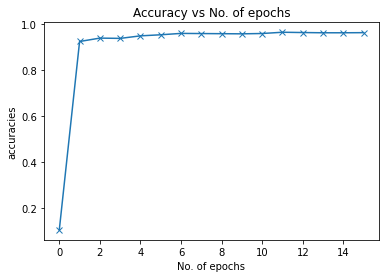

In [71]:
plt.plot(accuracies,"-x")
plt.xlabel('No. of epochs')
plt.ylabel("accuracies")
plt.title("Accuracy vs No. of epochs");